In [1]:
import torch
import torch.nn as nn
import os
import cv2
import numpy as np
import porespy as ps
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.models import resnet50, ResNet50_Weights
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from PIL import Image

ps.visualization.set_mpl_style()

In [3]:
''' Code to preprocess folder of images
def load_image (image_path):
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    # Crop the image to show only the central region
    height, width, _ = image.shape
    crop_width = 125
    cropped_image = image[:, crop_width:(width - crop_width)]
    gray = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2GRAY)
    return gray
    
def preprocess_image(image_path, output_folder, image_name):
    # Read the image
    image = load_image(image_path)
    
    # Apply adaptive thresholding to segment the image
    _, segmented = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Find contours in the segmented image
    contours, _ = cv2.findContours(segmented.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Iterate over the contours and draw them on the original image
    for contour in contours:
        # Calculate the area of the contour
        area = cv2.contourArea(contour)

        # If the area is smaller than a certain threshold, consider it as a pore
        if area < 100:
            cv2.drawContours(segmented, [contour], -1, (0, 0, 0), -1)
        else:
            cv2.drawContours(segmented, [contour], -1, (255, 255, 255), -1)

    # Save the preprocessed image with the original .tif extension
    processed_image_path = os.path.join(output_folder, image_name)
    cv2.imwrite(processed_image_path, image)
    return segmented, image

cropped_images = []
preprocessed_images = []
for image_file in os.listdir(input_folder):
    if image_file.endswith(".tif"):
        image_path = os.path.join(input_folder, image_file)
        image, cropped_image = preprocess_image(image_path, output_folder, image_file)
        preprocessed_images.append(image)
        cropped_images.append(cropped_image)

np.save('preprocessed_images.npy', preprocessed_images)
'''

' Code to preprocess folder of images\ndef load_image (image_path):\n    image = cv2.imread(image_path, cv2.IMREAD_COLOR)\n    # Crop the image to show only the central region\n    height, width, _ = image.shape\n    crop_width = 125\n    cropped_image = image[:, crop_width:(width - crop_width)]\n    gray = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2GRAY)\n    return gray\n    \ndef preprocess_image(image_path, output_folder, image_name):\n    # Read the image\n    image = load_image(image_path)\n    \n    # Apply adaptive thresholding to segment the image\n    _, segmented = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)\n\n    # Find contours in the segmented image\n    contours, _ = cv2.findContours(segmented.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)\n\n    # Iterate over the contours and draw them on the original image\n    for contour in contours:\n        # Calculate the area of the contour\n        area = cv2.contourArea(contour)\n\n    

In [2]:
preprocessed_np = np.load("preprocessed_images.npy")

In [3]:
images_np = np.load("images.npy")

In [4]:
preprocessed_np.shape

(1275, 64, 64, 3)

In [5]:
def generate_porosity_dataset(images):
    porosity = []
    for image in images:
        mask = image == 255
        porosity.append(ps.metrics.porosity(mask))
    return porosity

porosity = generate_porosity_dataset(preprocessed_np)

In [23]:
np.save("porosity.npy",porosity)

In [24]:
porosity_np = np.load("porosity.npy")

In [6]:
images = []
for image in preprocessed_np:
    images.append(image)
len(images)

1275

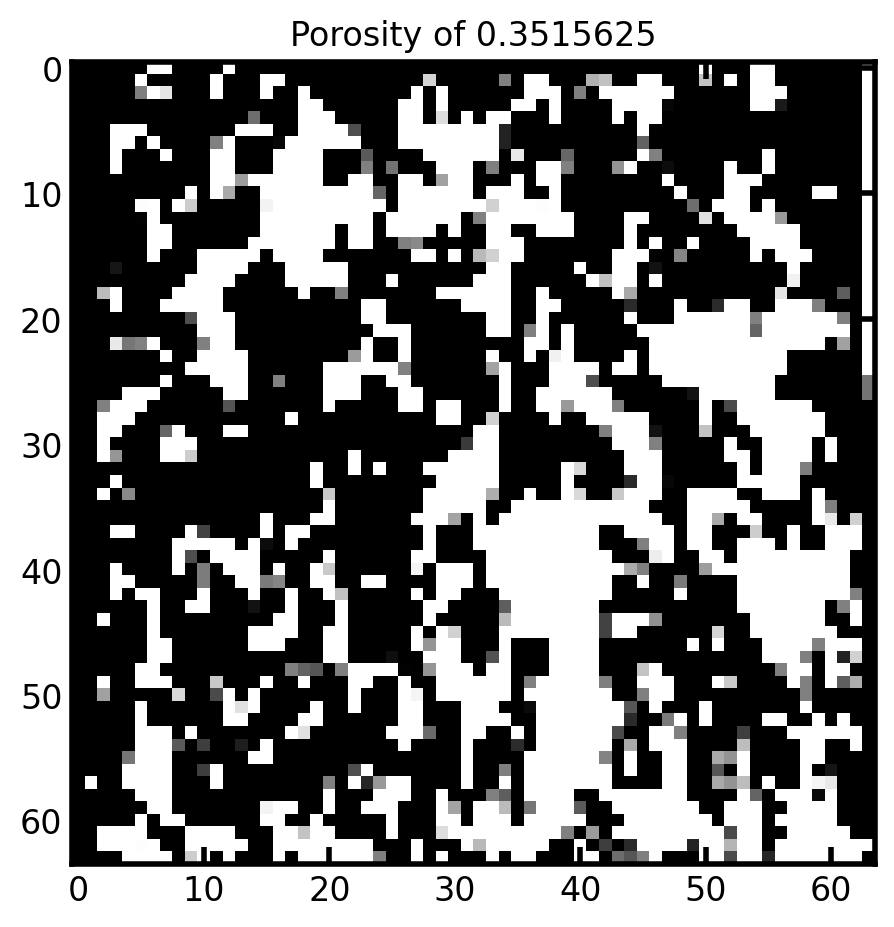

In [8]:
plt.imshow(preprocessed_np[0], cmap='gray')
plt.title(f'Porosity of {porosity[0]}')
plt.savefig("porousmedia.png")

In [27]:
# Define the combined model
class ResNetLSTM(nn.Module):
    def __init__(self, lstm_hidden_size, lstm_num_layers, porosity_input_size):
        super(ResNetLSTM, self).__init__()

        # Pre-trained ResNet model
        self.resnet = models.resnet50(weights=ResNet50_Weights.DEFAULT)
        self.resnet = nn.Sequential(*list(self.resnet.children())[:-2])  # Remove last classification layers

        # Add global average pooling layer
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))

        # LSTM model
        self.lstm = nn.LSTM(input_size=2048, hidden_size=lstm_hidden_size, num_layers=lstm_num_layers, batch_first=True)

        # Porosity prediction layer
        self.porosity_layer = nn.Linear(lstm_hidden_size, porosity_input_size)

    def forward(self, x):
        batch_size, sequence_length, channels, height, width = x.size()

        # Reshape for ResNet
        x_resized = x.view(-1, channels, height, width)
        features = self.resnet(x_resized)
        features = self.global_avg_pool(features)
        features = features.view(batch_size, sequence_length, -1)

        # LSTM input
        lstm_output, _ = self.lstm(features)

        # Predict porosity
        porosity_output = self.porosity_layer(lstm_output[:, -1, :])

        return porosity_output

class ResNetLSTMModel(nn.Module):
    def __init__(self, lstm_hidden_size, lstm_layers):
        super(ResNetLSTMModel, self).__init__()
        self.resnet = models.resnet50(weights=ResNet50_Weights.DEFAULT)
        self.resnet.fc = nn.Identity()  # Remove classification layer
        self.lstm = nn.LSTM(input_size=2048, hidden_size=lstm_hidden_size, num_layers=lstm_layers)
        self.linear = nn.Linear(lstm_hidden_size, 1)  # Predicting porosity value
    
    def forward(self, x):
        # ResNet feature extraction
        features = []
        for img in x:
            features.append(self.resnet(img))
        features = torch.stack(features)
        
        # LSTM sequence processing
        lstm_out, _ = self.lstm(features)
        
        # Final prediction
        lstm_out_last = lstm_out[-1]  # Considering the last output in the sequence
        prediction = self.linear(lstm_out_last)
        return prediction

In [31]:
class ImageSequenceDataset(Dataset):
    def __init__(self, images, porosity, sequence_length=10, transform=None):
        self.images = images
        self.porosity = porosity
        self.sequence_length = sequence_length
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        start_idx = idx
        end_idx = idx + self.sequence_length
        if end_idx <= len(self.images):
            sequence = self.images[start_idx:end_idx]
            porosity_sequence = self.porosity[start_idx:end_idx]
        else:
            sequence = self.images[start_idx:] + self.images[:end_idx - len(self.images)]
            porosity_sequence = self.porosity[start_idx:] + self.porosity[:end_idx - len(self.porosity)]
            
        sequence = [Image.fromarray(image) for image in sequence]
        if self.transform:
            transformed_sequence = [self.transform(image) for image in sequence]
            sequence = torch.stack(transformed_sequence) 
        porosity_sequence = torch.tensor(porosity_sequence, dtype=torch.float32)
        return sequence, porosity_sequence

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

In [32]:
# Create the dataset
from sklearn.model_selection import train_test_split

# Split the data into train, valid, and test sets (80%, 10%, 10%)

train_sequences, test_sequences, train_porosity, test_porosity = train_test_split(images, porosity, test_size=0.2, random_state=42)
valid_sequences, test_sequences, valid_porosity, test_porosity = train_test_split(test_sequences, test_porosity, test_size=0.5, random_state=42)


train_dataset = ImageSequenceDataset(train_sequences, train_porosity, transform=transform)
valid_dataset = ImageSequenceDataset(valid_sequences, valid_porosity, transform=transform)
test_dataset = ImageSequenceDataset(test_sequences, test_porosity, transform=transform)

# Create DataLoaders
batch_size = 16  # Adjust as needed
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [36]:
for batch_idx, (inputs, targets) in enumerate(train_loader):
    print(f"Batch {batch_idx + 1}: Input shape - {inputs.shape}, Target shape - {targets.shape}")

Batch 1: Input shape - torch.Size([16, 10, 3, 64, 64]), Target shape - torch.Size([16, 10])
Batch 2: Input shape - torch.Size([16, 10, 3, 64, 64]), Target shape - torch.Size([16, 10])
Batch 3: Input shape - torch.Size([16, 10, 3, 64, 64]), Target shape - torch.Size([16, 10])
Batch 4: Input shape - torch.Size([16, 10, 3, 64, 64]), Target shape - torch.Size([16, 10])
Batch 5: Input shape - torch.Size([16, 10, 3, 64, 64]), Target shape - torch.Size([16, 10])
Batch 6: Input shape - torch.Size([16, 10, 3, 64, 64]), Target shape - torch.Size([16, 10])
Batch 7: Input shape - torch.Size([16, 10, 3, 64, 64]), Target shape - torch.Size([16, 10])
Batch 8: Input shape - torch.Size([16, 10, 3, 64, 64]), Target shape - torch.Size([16, 10])
Batch 9: Input shape - torch.Size([16, 10, 3, 64, 64]), Target shape - torch.Size([16, 10])
Batch 10: Input shape - torch.Size([16, 10, 3, 64, 64]), Target shape - torch.Size([16, 10])
Batch 11: Input shape - torch.Size([16, 10, 3, 64, 64]), Target shape - torch.S

In [83]:
def evaluate_model(model, dataloader):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for batch_images, batch_porosity_labels in dataloader:
            # Forward pass
            predicted_porosity = model(batch_images)
            # Calculate loss
            loss = criterion(predicted_porosity, batch_porosity_labels.unsqueeze(1).float())
            total_loss += loss.item()
    average_loss = total_loss / len(dataloader)
    return average_loss

In [84]:
model = ResNetLSTMModel(lstm_hidden_size=64, lstm_layers=2)

In [85]:
import torch.optim as optim

train_losses = []
val_losses = []
# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    for batch_images, batch_porosity_labels in train_loader:
        optimizer.zero_grad()
        # Forward pass
        predicted_porosity = model(batch_images)
        # Calculate loss
        loss = criterion(predicted_porosity, batch_porosity_labels.unsqueeze(1).float())
        total_loss += loss.item()
        # Backpropagation and optimization
        loss.backward()
        optimizer.step()
    average_loss = total_loss / len(train_loader)
    train_losses.append(average_loss)
    val_loss = evaluate_model(model, valid_loader)
    val_losses.append(val_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {average_loss:.4f} - Val Loss: {val_loss:.4f}")

print("Training finished.")



Epoch [1/20] - Train Loss: 0.0197 - Val Loss: 0.0079
Epoch [2/20] - Train Loss: 0.0086 - Val Loss: 0.0094
Epoch [3/20] - Train Loss: 0.0083 - Val Loss: 0.0076
Epoch [4/20] - Train Loss: 0.0082 - Val Loss: 0.0075
Epoch [5/20] - Train Loss: 0.0081 - Val Loss: 0.0082
Epoch [6/20] - Train Loss: 0.0083 - Val Loss: 0.0107
Epoch [7/20] - Train Loss: 0.0087 - Val Loss: 0.0075
Epoch [8/20] - Train Loss: 0.0085 - Val Loss: 0.0082
Epoch [9/20] - Train Loss: 0.0081 - Val Loss: 0.0075
Epoch [10/20] - Train Loss: 0.0080 - Val Loss: 0.0082
Epoch [11/20] - Train Loss: 0.0078 - Val Loss: 0.0089
Epoch [12/20] - Train Loss: 0.0081 - Val Loss: 0.0075
Epoch [13/20] - Train Loss: 0.0082 - Val Loss: 0.0077
Epoch [14/20] - Train Loss: 0.0080 - Val Loss: 0.0082
Epoch [15/20] - Train Loss: 0.0078 - Val Loss: 0.0103
Epoch [16/20] - Train Loss: 0.0079 - Val Loss: 0.0078
Epoch [17/20] - Train Loss: 0.0080 - Val Loss: 0.0075
Epoch [18/20] - Train Loss: 0.0080 - Val Loss: 0.0090
Epoch [19/20] - Train Loss: 0.0078 - 

In [86]:
np.save('train_losses1.npy',train_losses)
np.save('val_losses1.npy', val_losses)

In [87]:
model_path = 'resnet_lstm_model2.pth'  # Provide a path for the saved model
torch.save(model.state_dict(), model_path)


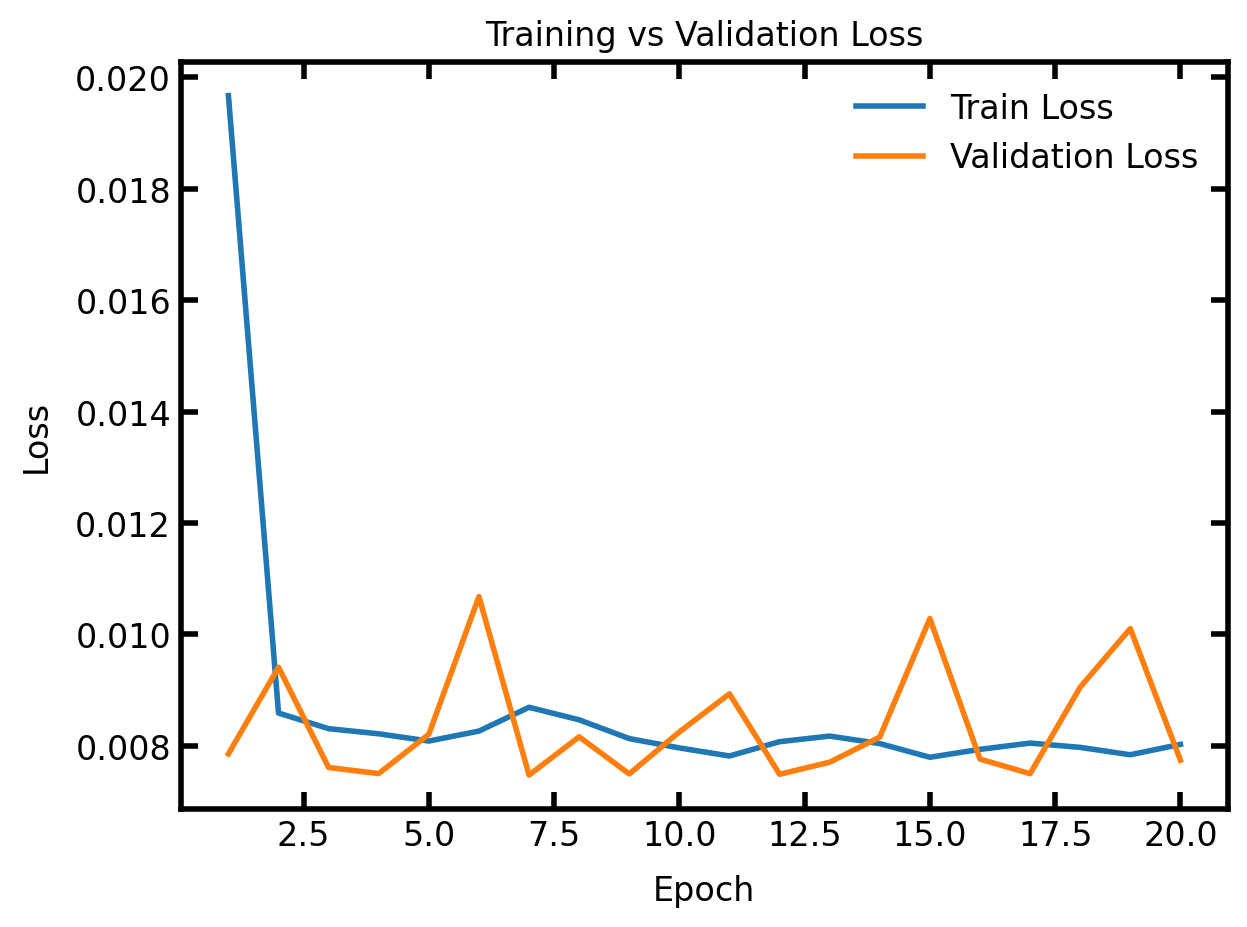

In [90]:
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
loss_graph_path = 'train_valid_loss.png'  # Provide a path for the saved graph
plt.savefig(loss_graph_path)

In [148]:
model.eval()

# Choose an index for the test dataset
rmse_values = []
predicted_porosity_values = []
# Get the sequence of images and porosities for the chosen sample
for idx in range(len(test_dataset)):
    
    sample_images, sample_porosity = test_dataset[idx]
    
    # Make the prediction
    with torch.no_grad():
        predicted_porosity = model(sample_images.unsqueeze(0))  # Add a batch dimension
    
    
    print("Predicted Porosity: ", idx,  predicted_porosity)
    print("Actual Porosity:", sample_porosity)
    
    predicted_porosity = predicted_porosity.numpy()
    predicted_porosity_values.append(predicted_porosity)
    sample_porosity = sample_porosity.numpy()
    # Calculation of RMSE
    actual_porosity = sample_porosity
    squared_errors = np.square(predicted_porosity - actual_porosity)
    mean_squared_error = np.mean(squared_errors)
    rmse = np.sqrt(mean_squared_error)
    rmse_values.append(rmse)



Predicted Porosity:  0 tensor([[0.1258],
        [0.1212],
        [0.1487],
        [0.1324],
        [0.0771],
        [0.0963],
        [0.1294],
        [0.1115],
        [0.1511],
        [0.1038]])
Actual Porosity: tensor([0.3489, 0.3564, 0.3384, 0.3733, 0.2517, 0.3186, 0.3403, 0.3357, 0.3376,
        0.3359])
Predicted Porosity:  1 tensor([[0.1212],
        [0.1487],
        [0.1324],
        [0.0771],
        [0.0963],
        [0.1294],
        [0.1115],
        [0.1511],
        [0.1038],
        [0.1267]])
Actual Porosity: tensor([0.3564, 0.3384, 0.3733, 0.2517, 0.3186, 0.3403, 0.3357, 0.3376, 0.3359,
        0.3391])
Predicted Porosity:  2 tensor([[0.1487],
        [0.1324],
        [0.0771],
        [0.0963],
        [0.1294],
        [0.1115],
        [0.1511],
        [0.1038],
        [0.1267],
        [0.1228]])
Actual Porosity: tensor([0.3384, 0.3733, 0.2517, 0.3186, 0.3403, 0.3357, 0.3376, 0.3359, 0.3391,
        0.2800])
Predicted Porosity:  3 tensor([[0.1324],
     

In [129]:
print(rmse_values)

[0.21724738, 0.216155, 0.20886536, 0.25755876, 0.25781918, 0.27543053, 0.2725102, 0.269891, 0.26659375, 0.26978096, 0.26352626, 0.2627317, 0.26416913, 0.2258198, 0.21610352, 0.19722281, 0.19887005, 0.19523211, 0.19794701, 0.19368014, 0.2084696, 0.207815, 0.21303947, 0.20312253, 0.2104533, 0.26843095, 0.2888783, 0.2884004, 0.30204907, 0.30352864, 0.296998, 0.32050246, 0.3202707, 0.3489413, 0.35115114, 0.30492294, 0.2861643, 0.28860787, 0.27135232, 0.26785108, 0.2700736, 0.24646816, 0.24332386, 0.20531537, 0.23181623, 0.23994453, 0.23481007, 0.25372908, 0.26192275, 0.2676209, 0.25896564, 0.2880869, 0.2921903, 0.29660624, 0.29756916, 0.29263577, 0.30373952, 0.29642975, 0.3182139, 0.3221877, 0.3277927, 0.30879867, 0.33941835, 0.33659488, 0.31592384, 0.31843716, 0.30797184, 0.30349097, 0.2798892, 0.27012616, 0.27173907, 0.25418434, 0.20527107, 0.20779197, 0.20436408, 0.19498064, 0.23476957, 0.23752008, 0.23240499, 0.23769882, 0.26603642, 0.26965445, 0.26934078, 0.25945863, 0.25496334, 0.254

In [150]:
mean_rmse = np.mean(rmse_values)

print("Mean:", mean_rmse)

Mean: 0.26213783


In [11]:
sample_images, sample_porosity = test_dataset[19]
predicted = predicted_porosity_values[19] 
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((128, 128)),  # Resize to the desired dimensions
    transforms.ToTensor(),
])

sample_images_resized = [transform(img) for img in sample_images]

# Create a figure with subplots
fig, axes = plt.subplots(2, 10, figsize=(20, 6))
fig.subplots_adjust(hspace=0.5)

# Plot original sequence images
for i, ax in enumerate(axes[0]):
    ax.imshow(sample_images_resized[i].permute(1, 2, 0).numpy(), cmap="gray")
    ax.set_title(f"Predicted\nTime Step {i}\nPorosity {sample_porosity[i].numpy():.4f}")
    ax.axis('off')

# Plot predicted sequence images
for i, ax in enumerate(axes[1]):
    im = ps.generators.blobs(shape=[128, 128], porosity=predicted[i][0], blobiness=2).astype(int)
    ax.imshow(im, cmap="gray")
    ax.set_title(f"Predicted\nTime Step {i}\nPorosity {predicted[i][0]:.4f}")
    ax.axis('off')

plt.tight_layout()
seq_prediction_path = 'sequence_prediction.png'  # Provide a path for the saved graph
plt.savefig(seq_prediction_path)

NameError: name 'test_dataset' is not defined